In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F    
from torch.optim import AdamW
from torch.optim import ASGD
from torch.amp.grad_scaler import GradScaler
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import time
from functools import partial

import json
import os

CHECKPOINT_DIR = os.path.join("..", "checkpoints", "neural_bigram", "hparams_search")
LOG_DIR = os.path.join("..", "logs", "neural_bigram", "hparams_search")
RESULTS_DIR = os.path.join("..", "results", "neural_bigram", "hparams_search")

os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

In [ ]:
# add parent directory to the path to allow imports
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from neural_bigram import NeuralBigram, ConfigNeuralBigram
from train_lm import train, evaluate, evaluate_ppl, ConfigTrain
from hparam_search_lm import hparams_search_nBigram, hparamsSpaceNBigram
from utils import init_dataloader, WarmupThenCosine, set_seed, count_params, save_checkpoint, load_checkpoint
from bpe_hf import train_bytelevel_bpe, train_and_encode_tokenizer, load_tokenizer, SPECIAL_TOKENS

## load data

In [3]:
data_dir = "data/"
# without nl
# train_file = "Shakespeare_clean_train.txt"
# val_file = "Shakespeare_clean_valid.txt"
# test_file = "Shakespeare_clean_test.txt"

# with nl
train_file = "Shakespeare_clean_w_nl_train.txt"
val_file = "Shakespeare_clean_w_nl_valid.txt"
test_file = "Shakespeare_clean_w_nl_test.txt"

train_file = os.path.join(data_dir, train_file)
test_file = os.path.join(data_dir, test_file)
val_file = os.path.join(data_dir, val_file)

with open(train_file, "r", encoding="utf-8") as f:
    train_text = f.read().strip()

with open(val_file, "r", encoding="utf-8") as f:
    val_text = f.read().strip()

with open(test_file, "r", encoding="utf-8") as f:
    test_text = f.read().strip()

print("train text charachters length: ", len(train_text))
print("train text words count: ", len(train_text.split()))
print("train text first 100 chars: ", train_text[:100])

train text charachters length:  883780
train text words count:  158605
train text first 100 chars:  The Tragedy of Antony and Cleopatra


Dramatis Personae



MARK ANTONY
OCTAVIUS CAESAR
M. AEMILIUS L


## define hyperparameters space

In [ ]:
SEED = 10
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# hyperparameters 
# data
BATCH_SIZE = 32
BLOCK_SIZE = 128

# tokenizer
N_MERGES = 200
MIN_FREQ = 2
SPECIAL_TOKENS = SPECIAL_TOKENS.copy()

#  model
DROPOUT = 0.1
# optimizer
LR = 3e-3
WEIGHT_DECAY = 1e-4
# scheduler
ETA_MIN = 1e-8

# training loop
EPOCHS = 60
ES_PATIENCE = 5
ES_TOLERANCE = 1e-6
GRAD_ACCUM_STEPS = 1
USE_AMP = False # IMPORTANT: set to False if training on CPU training 

# checkpoints
EVAL_INTERVAL = 2   # evaluate every n epochs
CKPT_INTERVAL = 10  # save checkpoint every n epochs

# config for training
cfg_train_base = ConfigTrain(device=DEVICE,
                    epochs=EPOCHS, 
                    early_stop_patience=ES_PATIENCE,
                    early_stop_tolerance=ES_TOLERANCE,
                    grad_accum_steps=GRAD_ACCUM_STEPS,
                    # max_grad_norm=data.get("max_grad_norm", 1.0),
                    use_amp=USE_AMP,
                    seed=SEED,
                    eval_interval=EVAL_INTERVAL,
                    ckpt_interval=CKPT_INTERVAL,
                    ckpt_dir=os.path.join(CHECKPOINT_DIR),
                    ckpt_best_filename="best.pt",
                    ckpt_last_filename="last.pt",
                    log_dir=os.path.join(LOG_DIR),
                    )
# config for model
cfg_model_base = ConfigNeuralBigram(
                    vocab_size=N_MERGES+256,
                    dropout=DROPOUT
                    )

cfg_hp_space = hparamsSpaceNBigram(
                            merges=(10, 200, 800,),
                            lr=(3e-4, 3e-3, 3e-2,),
                            dropout=(0.0, 0.3,),
                            weight_decay=(WEIGHT_DECAY,),
                            lr_scheduler=("cosine_warmup",),
                            )

hps_df_save_path = os.path.join(RESULTS_DIR, f"nBigram_hps_m{cfg_hp_space.merges}_lr{cfg_hp_space.lr}_d{cfg_hp_space.dropout}_{time.strftime('%y%m%d_%H%M%S')}.csv")

total_runs = np.prod([len(v) for k, v in cfg_hp_space.__dict__.items()])
print(f"Total runs: {total_runs}")

# log and checkpoint dir and filenames
print("log dir: ", cfg_train_base.log_dir)
print("checkpoint dir: ", cfg_train_base.ckpt_dir)
print("checkpoint best filename: ", cfg_train_base.ckpt_best_filename)
print("checkpoint last filename: ", cfg_train_base.ckpt_last_filename)
print("log dir: ", cfg_train_base.log_dir)
print("hparams search results: ", hps_df_save_path)

Total runs: 18
log dir:  logs/neural_bigram/hparams_search
checkpoint dir:  checkpoints/neural_bigram/hparams_search
checkpoint best filename:  best.pt
checkpoint last filename:  last.pt
log dir:  logs/neural_bigram/hparams_search
hparams search results:  results/neural_bigram/hparams_search/nBigram_hps_m(10, 200, 800)_lr(0.0003, 0.003, 0.03)_d(0.0, 0.3)_250824_182323.csv


## run hyperparameter search

In [ ]:
hparams_search_df = hparams_search_nBigram(
    hp_space=cfg_hp_space,
    train_text_path=train_file,
    val_text_path=val_file,
    # training base cfg
    base_cfg_train=cfg_train_base,
    # model base cfg
    base_cfg_model=cfg_model_base,
    # tokenizer
    tokenizer_trainer=train_bytelevel_bpe,
    special_tokens=SPECIAL_TOKENS,
    tok_min_frequency=MIN_FREQ,
    # data
    batch_size=BATCH_SIZE,
    block_size=BLOCK_SIZE,
    # lr scheduler
    eta_min=ETA_MIN,
    # I/O
    verbose=False,
)

HParams Search:   0%|          | 0/18 [00:00<?, ?trial/s]

W0824 15:31:32.292000 771453 torch/_dynamo/convert_frame.py:1016] [0/8] torch._dynamo hit config.recompile_limit (8)
W0824 15:31:32.292000 771453 torch/_dynamo/convert_frame.py:1016] [0/8]    function: 'forward' (/home/mj/Documents/Uni/wise25/building_gpt/Project/GPT_from_scratch/neural_bigram.py:23)
W0824 15:31:32.292000 771453 torch/_dynamo/convert_frame.py:1016] [0/8]    last reason: 0/7: GLOBAL_STATE changed: grad_mode 
W0824 15:31:32.292000 771453 torch/_dynamo/convert_frame.py:1016] [0/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0824 15:31:32.292000 771453 torch/_dynamo/convert_frame.py:1016] [0/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.


In [6]:
print(hparams_search_df.columns)
display(hparams_search_df.head())
best = hparams_search_df.iloc[0]
display("Best trial:", best.to_dict())

# save dataframe to CSV
hparams_search_df.to_csv(hps_df_save_path, index=False)

Index(['merges', 'lr', 'dropout', 'vocab_size', 'weight_decay', 'scheduler',
       'val_ppl', 'train_ppl', 'val_loss', 'train_loss', 'epochs', 'ckpt_best',
       'ckpt_last', 'full_config_file', 'run'],
      dtype='object')


,merges,lr,dropout,vocab_size,weight_decay,scheduler,val_ppl,train_ppl,val_loss,train_loss,epochs,ckpt_best,ckpt_last,full_config_file,run
0,10,0.030,0.0,270,0.0001,cosine_warmup,13.992119,14.030292,2.638494,2.641219,60,checkpoints/neural_bigram/hparams_search/best_...,checkpoints/neural_bigram/hparams_search/last_...,checkpoints/neural_bigram/hparams_search/hps_2...,hps_250824_152742_4eb023a2
1,10,0.003,0.0,270,0.0001,cosine_warmup,14.045205,14.089523,2.642281,2.645431,60,checkpoints/neural_bigram/hparams_search/best_...,checkpoints/neural_bigram/hparams_search/last_...,checkpoints/neural_bigram/hparams_search/hps_2...,hps_250824_152458_e0afe095
2,10,0.030,0.3,270,0.0001,cosine_warmup,14.765941,33.433804,2.692323,3.509568,60,checkpoints/neural_bigram/hparams_search/best_...,checkpoints/neural_bigram/hparams_search/last_...,checkpoints/neural_bigram/hparams_search/hps_2...,hps_250824_152843_29833205
3,10,0.003,0.3,270,0.0001,cosine_warmup,15.187371,33.507900,2.720464,3.511781,60,checkpoints/neural_bigram/hparams_search/best_...,checkpoints/neural_bigram/hparams_search/last_...,checkpoints/neural_bigram/hparams_search/hps_2...,hps_250824_152600_d58c34f6
4,200,0.030,0.0,460,0.0001,cosine_warmup,29.297115,27.972324,3.381829,3.331216,60,checkpoints/neural_bigram/hparams_search/best_...,checkpoints/neural_bigram/hparams_search/last_...,checkpoints/neural_bigram/hparams_search/hps_2...,hps_250824_153548_e86f729e


'Best trial:'

{'merges': 10,
 'lr': 0.03,
 'dropout': 0.0,
 'vocab_size': 270,
 'weight_decay': 0.0001,
 'scheduler': 'cosine_warmup',
 'val_ppl': 13.992118835449219,
 'train_ppl': 14.030291557312012,
 'val_loss': 2.6384943298504138,
 'train_loss': 2.6412185478118704,
 'epochs': 60,
 'ckpt_best': 'checkpoints/neural_bigram/hparams_search/best_hps_250824_152742_4eb023a2.pt',
 'ckpt_last': 'checkpoints/neural_bigram/hparams_search/last_hps_250824_152742_4eb023a2.pt',
 'full_config_file': 'checkpoints/neural_bigram/hparams_search/hps_250824_152742_4eb023a2_hparams.json',
 'run': 'hps_250824_152742_4eb023a2'}

In [6]:
# load the dataframe from CSV
from_hps_file = os.path.join(RESULTS_DIR, "nBigram_hps_m(10, 200, 800)_lr(0.0003, 0.003, 0.03)_d(0.0, 0.3)_250824_152206.csv")

hparams_search_df = pd.read_csv(from_hps_file)
display(hparams_search_df.head())

,merges,lr,dropout,vocab_size,weight_decay,scheduler,val_ppl,train_ppl,val_loss,train_loss,epochs,ckpt_best,ckpt_last,full_config_file,run
0,10,0.030,0.0,270,0.0001,cosine_warmup,13.992119,14.030292,2.638494,2.641219,60,checkpoints/neural_bigram/hparams_search/best_...,checkpoints/neural_bigram/hparams_search/last_...,checkpoints/neural_bigram/hparams_search/hps_2...,hps_250824_152742_4eb023a2
1,10,0.003,0.0,270,0.0001,cosine_warmup,14.045205,14.089523,2.642281,2.645431,60,checkpoints/neural_bigram/hparams_search/best_...,checkpoints/neural_bigram/hparams_search/last_...,checkpoints/neural_bigram/hparams_search/hps_2...,hps_250824_152458_e0afe095
2,10,0.030,0.3,270,0.0001,cosine_warmup,14.765941,33.433804,2.692323,3.509568,60,checkpoints/neural_bigram/hparams_search/best_...,checkpoints/neural_bigram/hparams_search/last_...,checkpoints/neural_bigram/hparams_search/hps_2...,hps_250824_152843_29833205
3,10,0.003,0.3,270,0.0001,cosine_warmup,15.187371,33.507900,2.720464,3.511781,60,checkpoints/neural_bigram/hparams_search/best_...,checkpoints/neural_bigram/hparams_search/last_...,checkpoints/neural_bigram/hparams_search/hps_2...,hps_250824_152600_d58c34f6
4,200,0.030,0.0,460,0.0001,cosine_warmup,29.297115,27.972324,3.381829,3.331216,60,checkpoints/neural_bigram/hparams_search/best_...,checkpoints/neural_bigram/hparams_search/last_...,checkpoints/neural_bigram/hparams_search/hps_2...,hps_250824_153548_e86f729e


## results and evaluation

In [2]:
from matplotlib import colormaps

def plot_hparams_search(
    df: pd.DataFrame,
    *,
    title: str = "HP Sweep — best val_ppl over dropouts (merges x lr)",
    save_path: str | None = None,
    show: bool = True,
    returns: bool = False,
):
    data = df.copy()
    required = {"merges", "lr", "val_ppl"}
    missing = required - set(data.columns)
    if missing:
        raise ValueError(f"df is missing columns: {missing}")
    # Ensure numeric
    for c in ["merges", "lr", "val_ppl"]:
        data[c] = pd.to_numeric(data[c], errors="coerce")
    data = data.dropna(subset=["merges", "lr", "val_ppl"])

    # plot
    fig, axs = plt.subplots(3,2, figsize=(24, 15), constrained_layout=True)
    axs = axs.flatten()  
    cmap = colormaps["plasma"]
    fig.suptitle(title, fontsize=16)

    # heatmap val_pll (merges, lr) over means dropout
    ax_hm = axs[0]
    best = data.groupby(["merges", "lr"], as_index=False)["val_ppl"].min()
    merges_vals = np.sort(best["merges"].unique())
    lr_vals     = np.sort(best["lr"].unique())
    dropout_vals = np.sort(data["dropout"].unique())
    pivot = best.pivot(index="lr", columns="merges", values="val_ppl").reindex(
        index=lr_vals, columns=merges_vals
    )
    im = ax_hm.imshow(pivot.values, aspect="auto", origin="lower", cmap=cmap)
    cbar = fig.colorbar(im, ax=ax_hm, fraction=0.046, pad=0.04)
    cbar.set_label("val_ppl")
    ax_hm.set_title("HM Best val_ppl by merges and per lr")
    ax_hm.set_xlabel("merges (k)")
    ax_hm.set_ylabel("learning rate (log10 scale)")
    ax_hm.set_xticks(np.arange(len(merges_vals)))
    ax_hm.set_xticklabels([f"{m}" for m in merges_vals], rotation=45, ha="right")
    ax_hm.set_yticks(np.arange(len(lr_vals)))
    ax_hm.set_yticklabels([f"{np.log10(lr):.1f}" for lr in lr_vals])
    ax_hm.set_xlim(-0.5, len(merges_vals) - 1 + 0.5)
    ax_hm.set_ylim(-0.5, len(lr_vals) - 1 + 0.5)
    # annotate best val_ppl overall with an arrow
    best_val_ppl = best["val_ppl"].min()
    best_idx = best["val_ppl"].idxmin()
    best_merges = best.loc[best_idx, "merges"]
    best_lr = best.loc[best_idx, "lr"]
    best_merges_idx = np.where(merges_vals == best_merges)[0][0]
    best_lr_idx = np.where(lr_vals == best_lr)[0][0]
    ax_hm.annotate(f"Best: {best_val_ppl:.2f}",
                   xy=(best_merges_idx, best_lr_idx),
                   xytext=(best_merges_idx + 0.5, best_lr_idx + 0.5),
                    arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
                    color='red', fontsize=12, fontweight='bold',)

    # lineplot for each lr and dropout, take best val_ppl for each (merges, lr) and (merges, dropout)
    ax_line_lr = axs[2]
    best_lr = (data.groupby(["merges","lr"], as_index=False)["val_ppl"]
               .min()
               .sort_values(["lr","merges"]))
    
    for lr in lr_vals:
        sub = best_lr[best_lr["lr"] == lr]
        if len(sub):
            ax_line_lr.plot(sub["merges"], sub["val_ppl"],
                                    marker="o", linewidth=1.8, label=f"lr={lr:.1e}", alpha=0.9)
    ax_line_lr.set_title("Best val_ppl by merges (per lr)")
    ax_line_lr.set_xlabel("merges (k)")
    ax_line_lr.set_ylabel("val_ppl")
    ax_line_lr.grid(alpha=0.7)
    ax_line_lr.legend(title="Learning rate", loc="upper right", fontsize=10)
    # best across lr for each (merges, dropout)
    best_do = (data.groupby(["merges","dropout"], as_index=False)["val_ppl"]
               .min()
               .sort_values(["dropout","merges"]))
    ax_line_dropout = axs[3]
    for d in data["dropout"].unique():
        sub = best_do[best_do["dropout"] == d]
        if len(sub):
            ax_line_dropout.plot(sub["merges"], sub["val_ppl"],
                                    linestyle="--", marker="s", linewidth=1.4,
                                    label=f"dropout={d:g}", alpha=0.8)
    ax_line_dropout.set_title("Best val_ppl by merges (per dropout)")   
    ax_line_dropout.set_xlabel("merges (k)")
    ax_line_dropout.set_ylabel("val_ppl")
    ax_line_dropout.grid(alpha=0.7)
    ax_line_dropout.legend(title="Dropout", loc="upper right", fontsize=10)

    # let both ax 1 and 2 have same y-axis limits
    y_min = min(ax_line_lr.get_ylim()[0], ax_line_dropout.get_ylim()[0])
    y_max = max(ax_line_lr.get_ylim()[1], ax_line_dropout.get_ylim()[1])
    ax_line_lr.set_ylim(y_min, y_max)
    ax_line_dropout.set_ylim(y_min, y_max)
    # plt.tight_layout()
    
    # plot variance of means
    ax_var = axs[1]
    total_var = data["val_ppl"].var(ddof=1) if len(data) > 1 else 0.0
    var_m = data.groupby("merges")["val_ppl"].mean().var(ddof=1) if len(merges_vals) > 1 else 0.0
    var_lr = data.groupby("lr")["val_ppl"].mean().var(ddof=1) if len(lr_vals) > 1 else 0.0
    var_d = data.groupby("dropout")["val_ppl"].mean().var(ddof=1) if len(dropout_vals) > 1 else 0.0
    # interaction terms
    var_m_lr = data.groupby(["merges", "lr"])["val_ppl"].mean().var(ddof=1) if len(merges_vals) > 1 and len(lr_vals) > 1 else 0.0
    var_m_d = data.groupby(["merges", "dropout"])["val_ppl"].mean().var(ddof=1) if len(merges_vals) > 1 and len(dropout_vals) > 1 else 0.0
    var_lr_d = data.groupby(["lr", "dropout"])["val_ppl"].mean().var(ddof=1) if len(lr_vals) > 1 and len(dropout_vals) > 1 else 0.0
    var_m_lr_d = data.groupby(["merges", "lr", "dropout"])["val_ppl"].mean().var(ddof=1) if len(merges_vals) > 1 and len(lr_vals) > 1 and len(dropout_vals) > 1 else 0.0
    parts = np.array([var_m, var_lr, var_d, var_m_lr, var_m_d, var_lr_d], dtype=float)
    if parts.sum() > 0:
        frac = parts / parts.sum()
    else:
        frac = np.zeros_like(parts)
        
    ax_var.barh(["merges", "lr", "dropout", "mergesXlr", "mergesXdropout", "lrXdropout"], frac, color=["tab:blue","tab:green","tab:purple","tab:orange","tab:red","tab:brown","tab:pink"])
    ax_var.set_xlim(0, 1)
    ax_var.set_title("Variance of means (normalized)")
    ax_var.set_xlabel("fraction of variance (~impact)")
    for y, v in enumerate(frac):
        ax_var.text(v + 0.01, y, f"{100*v:.1f}%", va="center")
    ax_var.grid(axis="x", alpha=0.3)
    

    # plot mean epoch for each lr and dropout
    norm_lr = lambda x: (x - np.log10(data["lr"].min())) / (np.log10(data["lr"].max()) - np.log10(data["lr"].min()))
    ax_mean_epoch = axs[4]
    mean_epoch_lr = data.groupby("lr", as_index=False)["epochs"].mean().sort_values("lr")
    ax_mean_epoch.bar(np.arange(len(mean_epoch_lr)), mean_epoch_lr["epochs"],
                      color=[cmap(norm_lr(np.log10(l))) for l in mean_epoch_lr["lr"]])
    ax_mean_epoch.set_title("Mean epochs by lr")
    ax_mean_epoch.set_xlabel("lr")
    ax_mean_epoch.set_ylabel("mean epochs")
    ax_mean_epoch.set_xticks(np.arange(len(mean_epoch_lr)))
    ax_mean_epoch.set_xticklabels([f"{l:.1e}" for l in mean_epoch_lr["lr"]], rotation=45, ha="right")
    ax_mean_epoch.grid(axis="y", alpha=0.3)
    
    # plot generalization gap (val vs train ppl)
    ax_gap = axs[5]

    if {"train_ppl","val_ppl"}.issubset(data.columns):
        # Cgap per run
        data["gap"] = (data["val_ppl"] - data["train_ppl"]) / data["train_ppl"]

        best_gap = (data.groupby(["merges","lr"], as_index=False)
                        .apply(lambda g: g.loc[g["val_ppl"].idxmin()][["gap","val_ppl","train_ppl"]])
                        .reset_index(drop=True))

        # pivot to heatmap
        pivot_gap = best_gap.pivot(index="lr", columns="merges", values="gap")
        merges_vals = np.sort(best_gap["merges"].unique())
        lr_vals     = np.sort(best_gap["lr"].unique())

        im = ax_gap.imshow(pivot_gap.values, aspect="auto", origin="lower", cmap="coolwarm", vmin=-0.5, vmax=0.5)
        cbar = fig.colorbar(im, ax=ax_gap, fraction=0.046, pad=0.04)
        cbar.set_label("Normalized gap (val-train)/train")

        ax_gap.set_title("Generalization Gap Heatmap (best dropout)", pad=8)
        ax_gap.set_xlabel("merges (k)")
        ax_gap.set_ylabel("learning rate (log10 scale)")
        ax_gap.set_xticks(np.arange(len(merges_vals)))
        ax_gap.set_xticklabels([f"{m}" for m in merges_vals], rotation=45, ha="right")
        ax_gap.set_yticks(np.arange(len(lr_vals)))
        ax_gap.set_yticklabels([f"{np.log10(l):.1f}" for l in lr_vals])
        ax_gap.set_xlim(-0.5, len(merges_vals)-0.5)
        ax_gap.set_ylim(-0.5, len(lr_vals)-0.5)

        # annotate hm 
        for i, lr in enumerate(lr_vals):
            for j, m in enumerate(merges_vals):
                val = pivot_gap.loc[lr, m]
                if pd.notna(val):
                    ax_gap.text(j, i, f"{val:+.2f}", ha="center", va="center", fontsize=8, color="black")

    if save_path:
        import os
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=150, bbox_inches="tight")

    if show:
        plt.show()

    if returns:
        return fig, ax_hm, pivot


/tmp/ipykernel_12783/592347042.py:151: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.loc[g["val_ppl"].idxmin()][["gap","val_ppl","train_ppl"]])


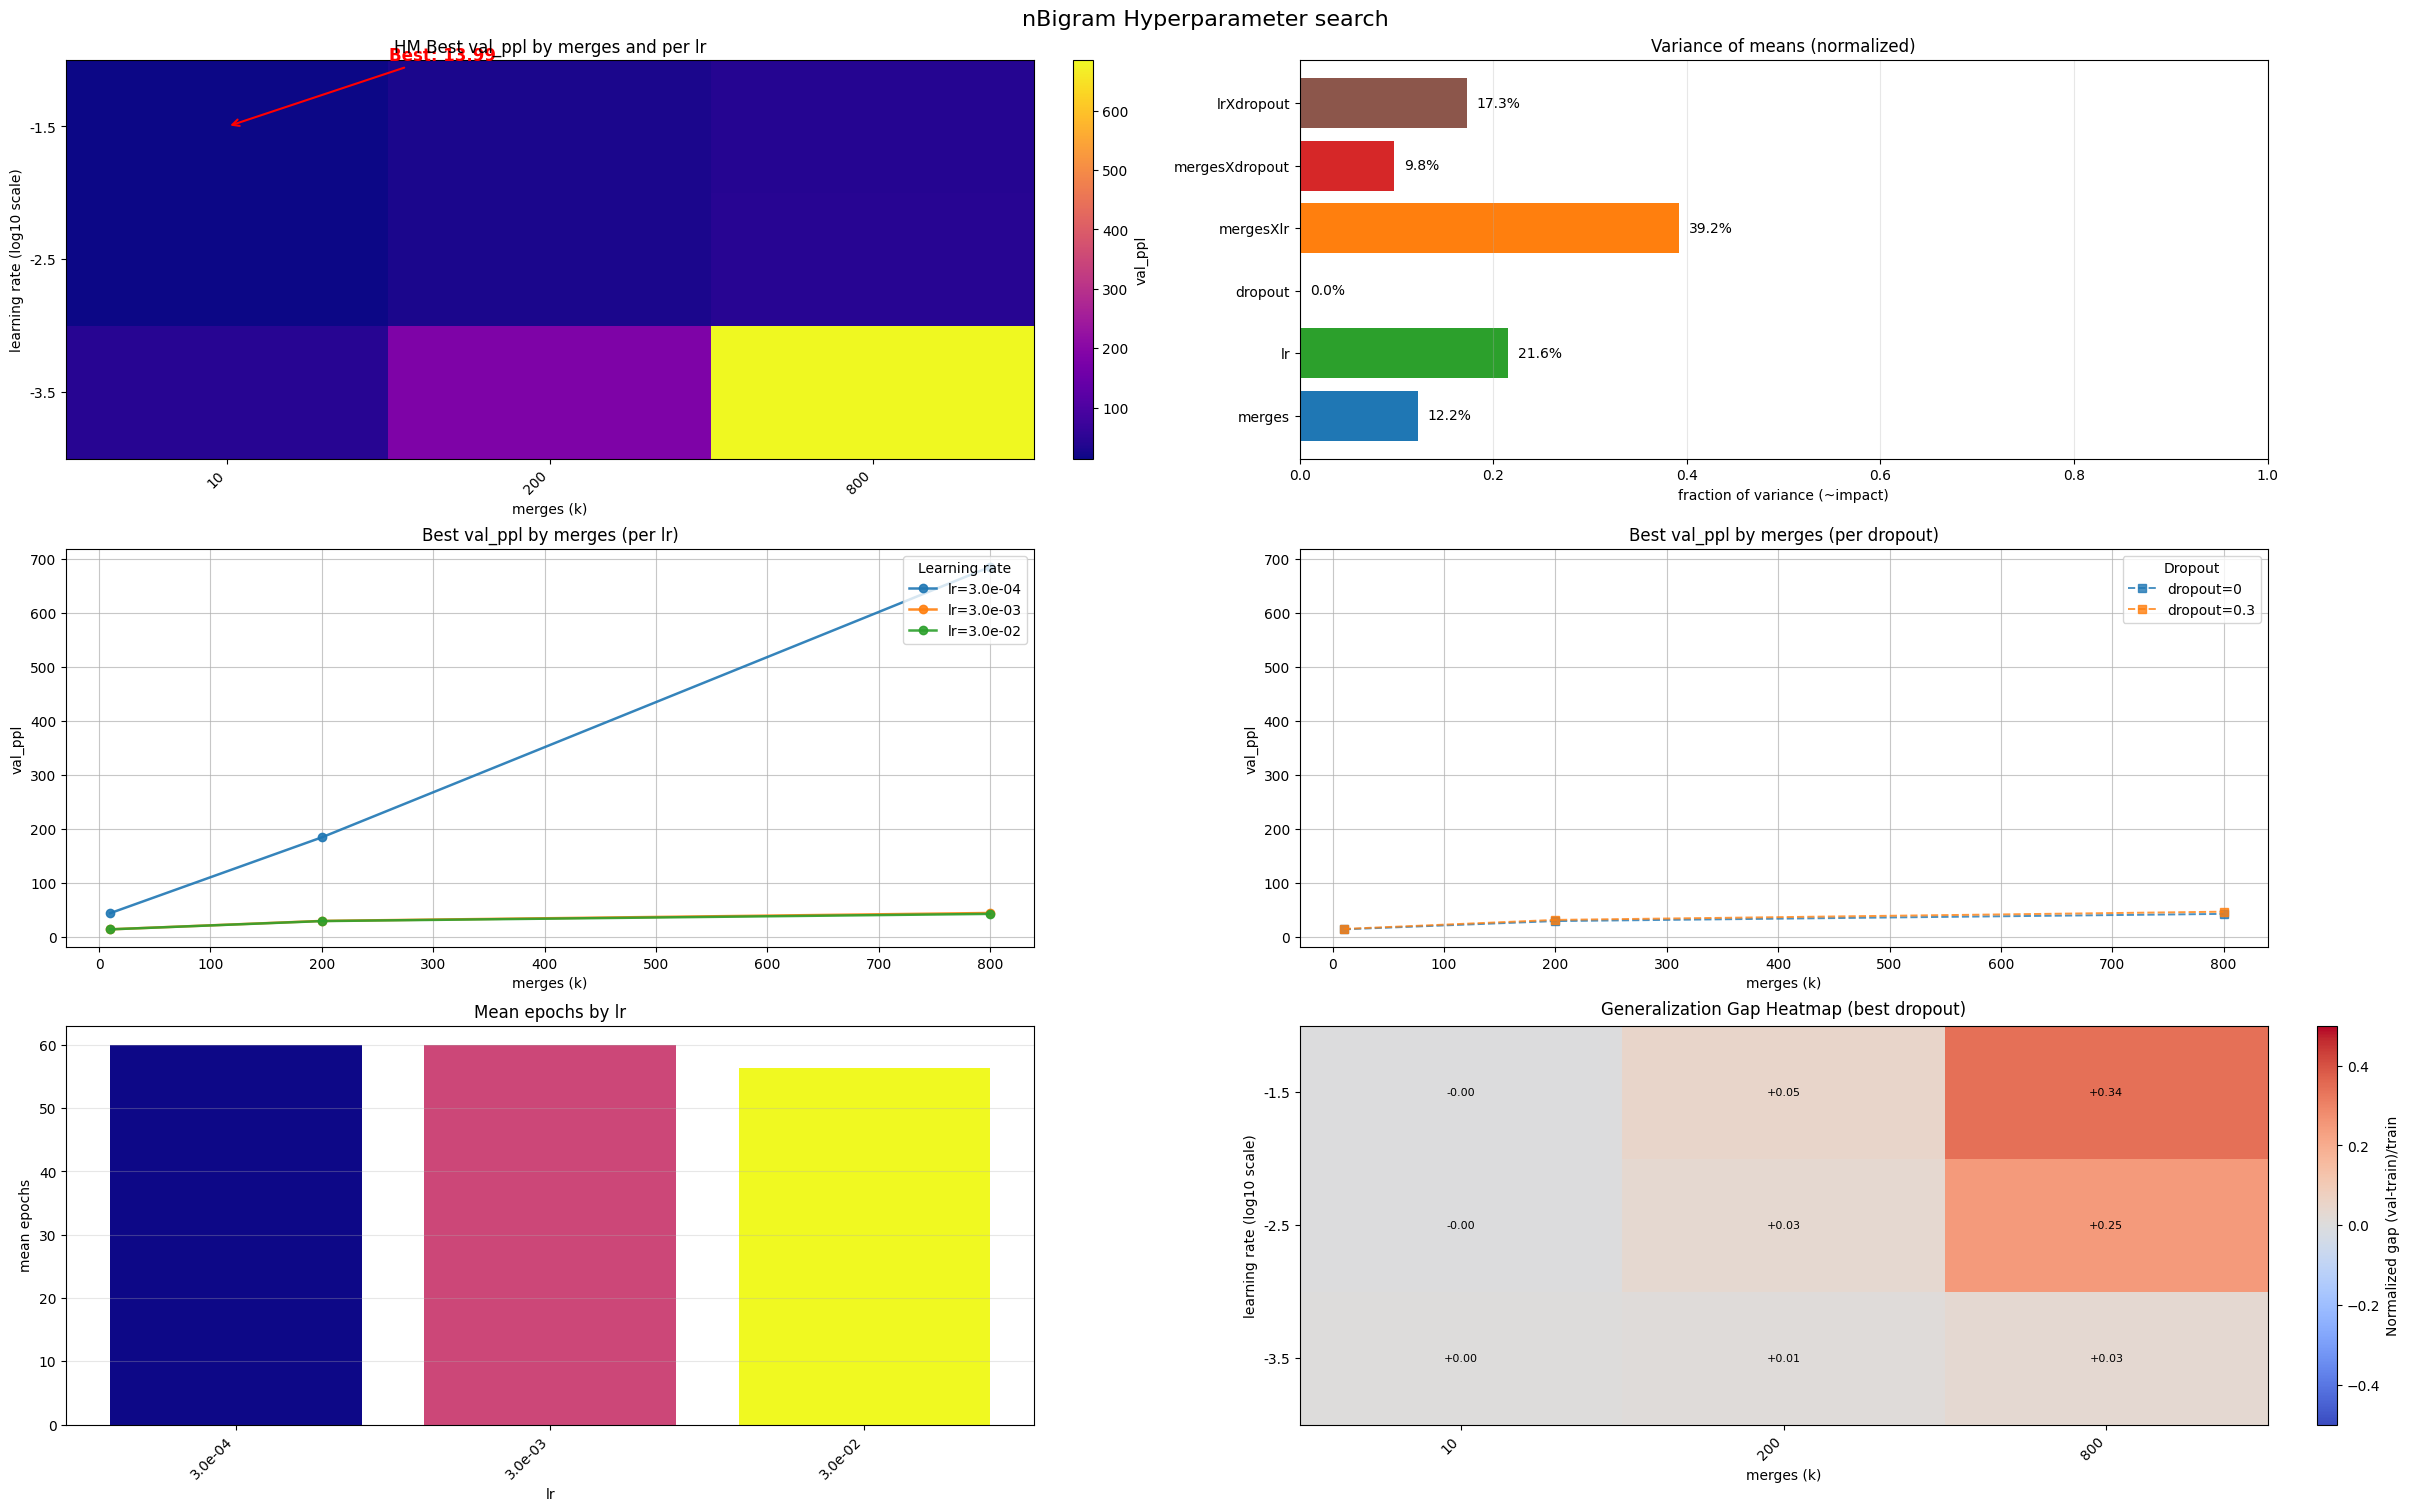

In [8]:
plot_hparams_search(
    hparams_search_df,
    title="nBigram Hyperparameter search",
    save_path=os.path.join(RESULTS_DIR, "nBigram_hparams_heatmap.png"),
    show=True,
    returns=False,
)

In [9]:
# sort results by val_ppl
hparams_seach__sorted = hparams_search_df.sort_values(by="val_ppl").reset_index(drop=True)
hparams_seach__sorted = hparams_seach__sorted[['val_ppl', 'train_ppl', 
                                               'merges', 'lr', 'dropout', 
                                               'run', 'ckpt_best', 'ckpt_last', 'full_config_file']]
print("Best hyperparameters:")
display(hparams_seach__sorted.head(1))

# get best hyperparameters per merges
best_per_merges = hparams_seach__sorted.loc[hparams_seach__sorted.groupby("merges")["val_ppl"].idxmin()].reset_index(drop=True)
best_per_merges = best_per_merges.sort_values(by="merges").reset_index(drop=True)
print("Best hyperparameters per merges:")
display(best_per_merges)

Best hyperparameters:


,val_ppl,train_ppl,merges,lr,dropout,run,ckpt_best,ckpt_last,full_config_file
0,13.992119,14.030292,10,0.03,0.0,hps_250824_152742_4eb023a2,checkpoints/neural_bigram/hparams_search/best_...,checkpoints/neural_bigram/hparams_search/last_...,checkpoints/neural_bigram/hparams_search/hps_2...


Best hyperparameters per merges:


,val_ppl,train_ppl,merges,lr,dropout,run,ckpt_best,ckpt_last,full_config_file
0,13.992119,14.030292,10,0.03,0.0,hps_250824_152742_4eb023a2,checkpoints/neural_bigram/hparams_search/best_...,checkpoints/neural_bigram/hparams_search/last_...,checkpoints/neural_bigram/hparams_search/hps_2...
1,29.297115,27.972324,200,0.03,0.0,hps_250824_153548_e86f729e,checkpoints/neural_bigram/hparams_search/best_...,checkpoints/neural_bigram/hparams_search/last_...,checkpoints/neural_bigram/hparams_search/hps_2...
2,42.644505,31.805927,800,0.03,0.0,hps_250824_155428_3e82a3a5,checkpoints/neural_bigram/hparams_search/best_...,checkpoints/neural_bigram/hparams_search/last_...,checkpoints/neural_bigram/hparams_search/hps_2...


### generate text from the best model per num merges

In [ ]:
test_runs = []
# load the best model for each merges
for merges in best_per_merges["merges"].unique():
    best_row = best_per_merges[best_per_merges["merges"] == merges].iloc[0]
    run_name = best_row["run"]
    ckpt_path = os.path.join(best_row['ckpt_best'])
    # if best ckpt does not exist, use last
    if not os.path.exists(ckpt_path):
        print(f"Best checkpoint {ckpt_path} does not exist, using last checkpoint instead.")
        ckpt_path = os.path.join(best_row['ckpt_last'])
        if not os.path.exists(ckpt_path):
            print(f"Last checkpoint {ckpt_path} also does not exist, skipping this run.")
            continue

    print(f"Loading best model for merges={merges} from {ckpt_path}")
    full_cfg_file = best_row['full_config_file']
    full_cfg_ = json.load(open(os.path.join(full_cfg_file), "r"))
    print(f"Loaded config from {full_cfg_file}")
    ckpt = load_checkpoint(ckpt_path, map_location=full_cfg_["training"]["device"], weights_only=False)
    
    # tokenizer 
    tokenizer = train_bytelevel_bpe(
        files=[train_file],
        merges=merges,
        min_frequency=full_cfg_['tokenizer'].get("min_frequency", 2),
        lowercase=full_cfg_['tokenizer'].get("lowercase", False),
        add_prefix_space=full_cfg_['tokenizer'].get("add_prefix_space", True),
        special_tokens=full_cfg_['tokenizer'].get("special_tokens", SPECIAL_TOKENS),
    )
    encode = partial(tokenizer.encode, add_special_tokens=False)
    pad_id = tokenizer.token_to_id(SPECIAL_TOKENS.get("bos", "<bos>"))
    decode = tokenizer.decode
    vocab_size = tokenizer.get_vocab_size()
    
    # data
    # train_ids = encode(train_text).ids
    # val_ids = encode(val_text).ids
    test_ids = encode(test_text).ids

    test_loader = init_dataloader(
        test_ids, 
        block_size=full_cfg_['data']["block_size"],
        batch_size=full_cfg_['data']["batch_size"],
        train=False, 
    )
    # model
    model = NeuralBigram(
        ConfigNeuralBigram(
            vocab_size=full_cfg_['model']["vocab_size"],
            dropout=full_cfg_['model']["dropout"],
        )
    )
    model.load_state_dict(ckpt["model"])
    model.to(full_cfg_["training"]["device"])

    # get optimizer dynamicly from his class name
    optimizer_class = getattr(torch.optim, full_cfg_['optimizer']['type'])
    optimizer = optimizer_class(model.parameters(), lr=full_cfg_['optimizer']['lr'])
    optimizer.defaults.update({k:v for k,v in full_cfg_['optimizer']['defaults'].items()}) # update optimizer defaults with full config
    # get scheduler dynamicly from his class name
    if full_cfg_['lr_scheduler']['type'] == "WarmupThenCosine":
        lr_scheduler_class = WarmupThenCosine
        lr_scheduler = lr_scheduler_class(optimizer, warmup_steps=full_cfg_['lr_scheduler']['state_dict']['warmup_steps'],
                                          T_max=full_cfg_['lr_scheduler']['state_dict']['T_max'],
                                          eta_min=full_cfg_['lr_scheduler']['state_dict']['eta_min'],)
    else:
        lr_scheduler_class = getattr(torch.optim.lr_scheduler, full_cfg_['lr_scheduler']['type'])
        lr_scheduler = lr_scheduler_class(optimizer)
        lr_scheduler.load_state_dict({k:v for k,v in full_cfg_['lr_scheduler'].items() if k != 'name'})  # update scheduler state dict with full config

    # get scaler dynamicly from his class name
    scaler_class = getattr(torch.amp, full_cfg_['scaler']['type'])
    scaler = scaler_class(enabled=full_cfg_['training']['use_amp'])

    # evaluate the loaded model
    test_avg_loss = evaluate(model, test_loader, device=torch.device(full_cfg_["training"]["device"]))
    test_ppl = np.exp(test_avg_loss)
    
    
    # generate from the loaded model
    context = "To be, or not"
    context_ids = encode(context).ids
    context_ids = torch.tensor(context_ids, dtype=torch.long, device=DEVICE).unsqueeze(0)  # (1, T_in)
    print("Generating from model with:")
    print(f"merges={merges}, lr={full_cfg_['optimizer']['lr']:.6e}, dropout={full_cfg_['model']['dropout']}")
    print("model parameters count: ", count_params(model))
    print(f"Test PPL: {test_ppl:.2f}, val PPL: {best_row['val_ppl']:.2f}, train PPL: {best_row.get('train_ppl', None)}\n")
    print("\n>>>> ", decode(context_ids[0].tolist()), "\n", "-"*20, "\n")
    
    top_k = 20
    temperature = 1.2
    rep_penalty = 1.2
    print(f"\nsample with top_k={top_k}, t={temperature}, penalty={rep_penalty}\n")
    model.eval()
    generated_ids = model.generate(context_ids, max_new_tokens=50, mode="sample", 
                         top_k=top_k, temperature=temperature,
                         eos_id=tokenizer.token_to_id(SPECIAL_TOKENS.get("eos", "<eos>")))
    print("<<<< ", decode(generated_ids[0].tolist()), "\n")
    print("-"* 120 , "\n")

    test_runs.append({
        "test_loss": test_avg_loss,
        "test_ppl": test_ppl,
        "val_ppl": best_row["val_ppl"],
        "train_ppl": best_row["train_ppl"],
        "merges": merges,
        "lr": full_cfg_['optimizer']['lr'],
        "dropout": full_cfg_['model']['dropout'],
        "model_params_count": count_params(model),
        "run_name": run_name,
        "ckpt_path": ckpt_path,
        "generated_text_sample": decode(generated_ids[0].tolist()),
        "context": context,
    })
test_runs = pd.DataFrame(test_runs)
test_runs = test_runs.sort_values(by="test_ppl").reset_index(drop=True)
display(test_runs)

Loading best model for merges=10 from checkpoints/neural_bigram/hparams_search/best_hps_250824_152742_4eb023a2.pt
Loaded config from checkpoints/neural_bigram/hparams_search/hps_250824_152742_4eb023a2_hparams.json
Generating from model with:
merges=10, lr=3.000000e-02, dropout=0.0
model parameters count:  72900
Test PPL: 14.20, val PPL: 13.99, train PPL: 14.030291557312012


>>>>   To be, or not 
 -------------------- 


sample with top_k=20, t=1.2, penalty=1.2

<<<<   To be, or notte the mersto shawesth lliofandon y p ist ficr, whe enge 

------------------------------------------------------------------------------------------------------------------------ 

Loading best model for merges=200 from checkpoints/neural_bigram/hparams_search/best_hps_250824_153548_e86f729e.pt
Loaded config from checkpoints/neural_bigram/hparams_search/hps_250824_153548_e86f729e_hparams.json
Generating from model with:
merges=200, lr=3.000000e-02, dropout=0.0
model parameters count:  211600
Test PPL: 31.52

,test_loss,test_ppl,val_ppl,train_ppl,merges,lr,dropout,model_params_count,run_name,ckpt_path,generated_text_sample,context
0,2.653197,14.199361,13.992119,14.030292,10,0.03,0.0,72900,hps_250824_152742_4eb023a2,checkpoints/neural_bigram/hparams_search/best_...,"To be, or notte the mersto shawesth lliofando...","To be, or not"
1,3.450745,31.523882,29.297115,27.972324,200,0.03,0.0,211600,hps_250824_153548_e86f729e,checkpoints/neural_bigram/hparams_search/best_...,"To be, or not sonsikee\nCEN GEUS\nWookesark o...","To be, or not"
2,4.047380,57.247272,42.644505,31.805927,800,0.03,0.0,1123600,hps_250824_155428_3e82a3a5,checkpoints/neural_bigram/hparams_search/last_...,"To be, or not,\nOnow, forbals! Aleanquined: l...","To be, or not"


In [14]:
# save test text outputs to txt file
test_performance_file = os.path.join(RESULTS_DIR, "nBigram_test_performance.txt")
with open(test_performance_file, "w", encoding="utf-8") as f:
    f.write(f"Test performance of best models per merges from hparams search:\n")
    f.write(f"test generation format:\n")
    f.write(f">>>> <context>\n {'-' *20}\n<<<< <generated_text>")
    f.write("="*120 + "\n\n")
    for idx, run in test_runs.iterrows():
        f.write(f"merges={run['merges']}, lr={run['lr']:.6e}, dropout={run['dropout']}\n")
        f.write(f"model parameters count: {run['model_params_count']}\n")
        f.write(f"Test PPL: {run['test_ppl']:.2f}, val PPL: {run['val_ppl']:.2f}, train PPL: {run.get('train_ppl', None)}\n")
        f.write(f"\n>>>> {run['context']}\n{'-'*20}\n")
        f.write(f"<<<< {run['generated_text_sample']}\n")
        f.write(f"{'-' * 120}\n")
    print(f"Saved test performance to {test_performance_file}")
    f.close()

Saved test performance to results/neural_bigram/hparams_search/nBigram_test_performance.txt


### performance on test set

,merges,lr,dropout,train_ppl,val_ppl,test_ppl
0,10,0.03,0.0,14.030292,13.992119,14.199361
1,200,0.03,0.0,27.972324,29.297115,31.523882
2,800,0.03,0.0,31.805927,42.644505,57.247272


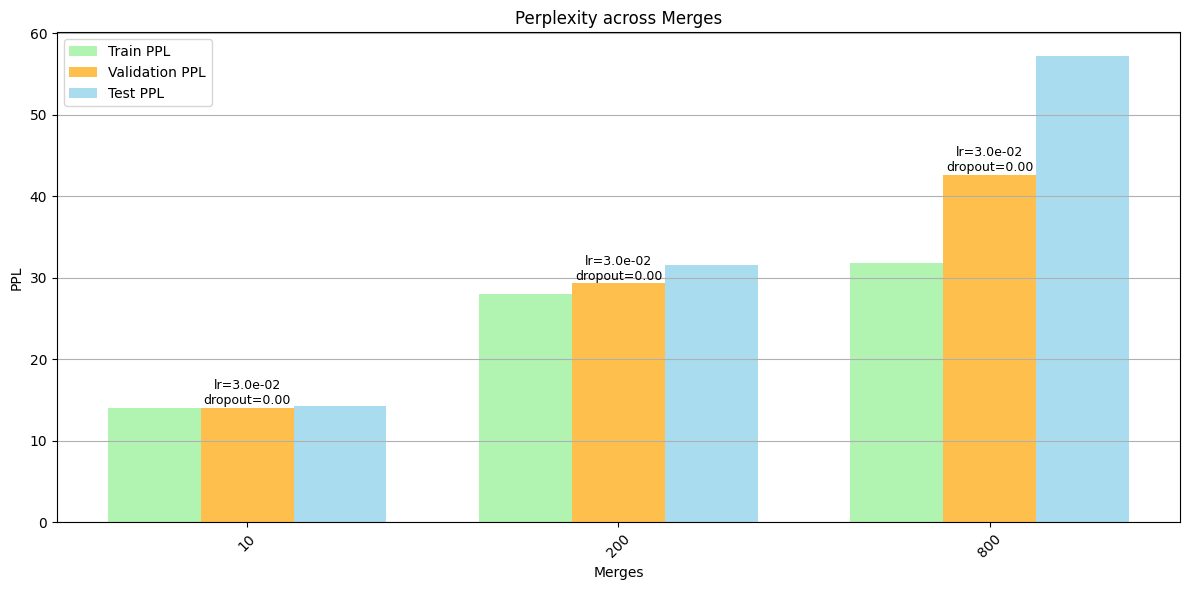

In [15]:
display(test_runs[['merges', 'lr', 'dropout', 'train_ppl', 'val_ppl', 'test_ppl']])
test_runs[['merges', 'lr', 'dropout', 'train_ppl', 'val_ppl', 'test_ppl']].to_csv(os.path.join(RESULTS_DIR, "nBigram_test_performance.csv"), index=False)

x = np.arange(len(best_per_merges['merges']))   
width = 0.25                 

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width, best_per_merges['train_ppl'], width, label="Train PPL", color="lightgreen", alpha=0.7)
ax.bar(x,         best_per_merges['val_ppl'],   width, label="Validation PPL", color="orange", alpha=0.7)
ax.bar(x + width, test_runs['test_ppl'],  width, label="Test PPL", color="skyblue", alpha=0.7)

# annotate the bars with the values with lr and dropout
for i, (lr, dropout) in enumerate(zip(best_per_merges['lr'], best_per_merges['dropout'])):
    ax.text(i,         best_per_merges['val_ppl'][i] + 0.1, f"lr={lr:.1e}\ndropout={dropout:.2f}", ha='center', va='bottom', fontsize=9)

ax.set_xticks(x)
ax.set_xticklabels(best_per_merges['merges'], rotation=45)
ax.set_title("Perplexity across Merges")
ax.set_xlabel("Merges")
ax.set_ylabel("PPL")
ax.grid(True, axis='y')
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "nBigram_test_results_ppl.png"), dpi=150, bbox_inches="tight")
plt.show()